In [1]:
# Prepare gym for agent
import gym
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Getting enviroment
env = gym.make('CartPole-v0')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [2]:
print(env.action_space)
env.reset()
state, reward, done, info = env.step(env.action_space.sample())
print(state)

Discrete(2)
[ 0.02881814 -0.18446311 -0.04327379  0.30948815]


Two possible actions [0,1]
State descrived by [position of cart, velocity of cart, angle of pole, rotation rate of pole].

Neural Network implementation to approximate the Q action value function.

## Experience Replay memory implementation.

In [94]:
from collections import deque
class Memory_exp_replay:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def add_timestep(self, env_reaction):
        # St, At, Rt1, St1.
        self.buffer.append(env_reaction)
        
    def sample_random(self, sample_size, debug=False):
        # Replace=False, important so it doesn't repeat a sample on the batch
        indexs = np.random.choice(a=np.arange(len(self.buffer)), size=sample_size, replace=False) 
        if debug:
            print(indexs)
        states = list()
        actions = list()
        rewards = list()
        next_states = list()
        for index in indexs:
            states.append(self.buffer[index][0])
            actions.append(self.buffer[index][1])
            rewards.append(self.buffer[index][2])
            next_states.append(self.buffer[index][3])
        batch = [np.array(states), np.array(actions), np.array(rewards), np.array(next_states)]
        return batch

Testing out the Memory Buffer.

In [95]:
# Initliaze memory
def populate_memory(env, exp_replay_memory, batch_size_Q, debug=False):
    if debug: 
        print('Order of enviroment reactions')
    content = 0
    s_t1 = env.reset()
    while content < batch_size_Q:
        s_t = s_t1 
        a_t = env.action_space.sample()
        s_t1, r_t1, done, info = env.step(a_t)
        if done:
            s_t1 = np.zeros(s_t.shape)
            if debug: 
                print(content, s_t)
            exp_replay_memory.add_timestep((s_t, a_t, r_t1, s_t1))
            s_t = env.reset()
        else:
            if debug: 
                print(content, s_t)
            exp_replay_memory.add_timestep((s_t, a_t, r_t1, s_t1))
        content += 1
    return exp_replay_memory

memory_size = 100000
batch_size_Q = 20

# Intantiate memory and populate
exp_replay = Memory_exp_replay(memory_size)
exp_replay = populate_memory(env, exp_replay, batch_size_Q, debug=True)

print('Random sample from Memory Buffer')
states, actions, rewards, next_states = exp_replay.sample_random(2, debug=True)
for state in states:
    print(state)

Order of enviroment reactions
0 [-0.0279756  -0.01825218 -0.03759038 -0.01097499]
1 [-0.02834064  0.17738814 -0.03780988 -0.31527713]
2 [-0.02479288  0.3730277  -0.04411542 -0.61964019]
3 [-0.01733233  0.56873714 -0.05650823 -0.92588446]
4 [-0.00595758  0.76457483 -0.07502592 -1.2357767 ]
5 [ 0.00933391  0.96057648 -0.09974145 -1.55098904]
6 [ 0.02854544  0.76678241 -0.13076123 -1.29101807]
7 [ 0.04388109  0.96330187 -0.15658159 -1.62161505]
8 [ 0.06314713  0.7703323  -0.18901389 -1.38154894]
9 [0. 0. 0. 0.]
10 [-0.00125512 -0.14961133 -0.00463465  0.32100127]
11 [-0.00424735 -0.34466697  0.00178538  0.61221901]
12 [-0.01114069 -0.14957002  0.01402976  0.32009895]
13 [-0.01413209  0.04534935  0.02043174  0.03187329]
14 [-0.0132251  -0.15005956  0.0210692   0.33093197]
15 [-0.0162263   0.04475624  0.02768784  0.04496702]
16 [-0.01533117 -0.15075157  0.02858718  0.34625552]
17 [-0.0183462  -0.34626825  0.03551229  0.6478142 ]
18 [-0.02527157 -0.54186649  0.04846858  0.951465  ]
19 [-0.03

### Memory working well.

## Q Value Neural Network inference.

In [130]:
# Defining NN for the action value function approximation.
class NN_Q_approx:
    def __init__(self, learning_rate, hidden_size, state_space, action_space, name):
        self.learning_rate = learning_rate
        self.state_space = state_space
        self.action_space = action_space
        self.name = name
        with tf.variable_scope(self.name):
            self.inputs = tf.placeholder(dtype=tf.float32, shape=[None, self.state_space], name='state_input')
            
            # Placeholder to choose the action value for the action done.
            self.actions = tf.placeholder(dtype=tf.int32, shape=[None], name='action_output')
            actions_oh = tf.one_hot(self.actions, self.action_space)
            
            self.target_Q = tf.placeholder(dtype=tf.float32, shape= [None], name='target_Q')
            
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)
            self.output = tf.contrib.layers.fully_connected(self.fc2, self.action_space, activation_fn=None)
            # Until here for action value prediction.
            
            # Q size [m, action_space] -> sum, size [m, 1]
            self.Q = tf.reduce_sum(tf.multiply(self.output, actions_oh), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.Q - self.target_Q))
            self.opt = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)     
            

Defining parameters for neural network and replay memory, to test out how NN performs to learn Q values.

In [236]:
# NN parameters.
learning_rate_nn = 0.0001
hidden_size = 128
state_space = len(state)
action_space = env.action_space.n

# Memory parameters.
memory_size = 100000
batch_size_Q = 32

# Training parameters.
max_episodes = 500
max_steps_episode = 300
gamma = 1

# Exploration parameters
max_epsilon = 1.0
min_epsilon = 0.01
decay_rate = 0.05  

Defining Epislon-Greedy Policy.

In [237]:
def epsilon_greedy(epsilon, q_value):
    probabilities = np.ones(q_value[0].shape)*epsilon/action_space
    probabilities[np.argmax(q_value[0])] = 1 - epsilon + (epsilon/action_space)
    action = np.random.choice(a=np.arange(action_space), size=1, p=probabilities)
    return int(action)

Code to run training.

In [239]:
# Intantiate memory and populate
exp_replay = Memory_exp_replay(memory_size)
exp_replay = populate_memory(env, exp_replay, batch_size_Q)

# Initiliaze TensorFlow Graph
tf.reset_default_graph()
Q_NN = NN_Q_approx(learning_rate=learning_rate_nn, hidden_size=hidden_size, state_space=state_space, action_space=action_space, name='Q_action_value')

training_rewards = list()
training_loss = list()
with tf.Session() as sess:
    # Initializa variables 
    sess.run(tf.global_variables_initializer())
    ep_iter = 0
    
    for i in range(1, max_episodes+1):
        # Intiliazing variables for episode.
        s_t1 = env.reset()
        time_step = 0
        episode_reward = 0
        
        while time_step < max_steps_episode:
            # Watch it learn.
            env.render()
            
            s_t = s_t1
            # Controling epsilon.
            ep_iter += 1
            epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*i) 
        
            # Find Q Values and select action under E-greedy policy.
            q_values = sess.run(Q_NN.output, feed_dict={Q_NN.inputs:np.array(s_t).reshape((1, -1))})
            a_t = epsilon_greedy(epsilon, q_values)

            s_t1, r_t1, done, info = env.step(a_t)
    
            episode_reward += gamma*r_t1
            time_step += 1
            
            if done:
                # Terminating episode
                time_step = max_steps_episode
                s_t1 = np.zeros(state_space)
                # Update memory
                exp_replay.add_timestep((s_t, a_t, r_t1, s_t1))

                # Tracking information
                training_rewards.append((i, episode_reward))
                training_loss.append((i, loss))
                print('Episode: {}'.format(i),
                      'Total reward: {:.4f}'.format(episode_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Epsilon: {:.4f}'.format(epsilon))
            else:
                # Update memory
                exp_replay.add_timestep((s_t, a_t, r_t1, s_t1))
            
            # Train network.
            states, actions, rewards, next_states = exp_replay.sample_random(batch_size_Q)
            estiamted_Qs = sess.run(Q_NN.output, feed_dict = {Q_NN.inputs:next_states})
            found_initial = (next_states == np.zeros(states[0].shape)).all(axis=1)
            estiamted_Qs[found_initial] = np.zeros(estiamted_Qs[0].shape)
            
            target_Qs = rewards + gamma*np.max(estiamted_Qs, axis=1)
            
            feed_dict = {Q_NN.inputs:states, Q_NN.actions:actions, Q_NN.target_Q: target_Qs}
            loss, _ = sess.run([Q_NN.loss, Q_NN.opt], feed_dict)
                    

Episode: 1 Total reward: 25.0000 Training loss: 1.0919 Epsilon: 0.9517
Episode: 2 Total reward: 10.0000 Training loss: 1.0827 Epsilon: 0.9058
Episode: 3 Total reward: 29.0000 Training loss: 1.1005 Epsilon: 0.8621
Episode: 4 Total reward: 21.0000 Training loss: 1.1744 Epsilon: 0.8205
Episode: 5 Total reward: 46.0000 Training loss: 1.3014 Epsilon: 0.7810
Episode: 6 Total reward: 12.0000 Training loss: 1.2677 Epsilon: 0.7434
Episode: 7 Total reward: 13.0000 Training loss: 1.5333 Epsilon: 0.7076
Episode: 8 Total reward: 13.0000 Training loss: 1.5284 Epsilon: 0.6736
Episode: 9 Total reward: 19.0000 Training loss: 1.5493 Epsilon: 0.6413
Episode: 10 Total reward: 33.0000 Training loss: 1.9086 Epsilon: 0.6105
Episode: 11 Total reward: 9.0000 Training loss: 2.4398 Epsilon: 0.5812
Episode: 12 Total reward: 10.0000 Training loss: 2.1286 Epsilon: 0.5533
Episode: 13 Total reward: 14.0000 Training loss: 2.4618 Epsilon: 0.5268
Episode: 14 Total reward: 13.0000 Training loss: 3.8425 Epsilon: 0.5016
Ep

Episode: 115 Total reward: 10.0000 Training loss: 46.2645 Epsilon: 0.0132
Episode: 116 Total reward: 10.0000 Training loss: 27.8998 Epsilon: 0.0130
Episode: 117 Total reward: 13.0000 Training loss: 4.0082 Epsilon: 0.0129
Episode: 118 Total reward: 12.0000 Training loss: 3.0673 Epsilon: 0.0127
Episode: 119 Total reward: 14.0000 Training loss: 5.9933 Epsilon: 0.0126
Episode: 120 Total reward: 13.0000 Training loss: 28.7278 Epsilon: 0.0125
Episode: 121 Total reward: 12.0000 Training loss: 28.5518 Epsilon: 0.0123
Episode: 122 Total reward: 12.0000 Training loss: 4.8754 Epsilon: 0.0122
Episode: 123 Total reward: 11.0000 Training loss: 23.0896 Epsilon: 0.0121
Episode: 124 Total reward: 14.0000 Training loss: 6.6480 Epsilon: 0.0120
Episode: 125 Total reward: 12.0000 Training loss: 19.3275 Epsilon: 0.0119
Episode: 126 Total reward: 13.0000 Training loss: 20.1645 Epsilon: 0.0118
Episode: 127 Total reward: 11.0000 Training loss: 22.2255 Epsilon: 0.0117
Episode: 128 Total reward: 13.0000 Training

Episode: 228 Total reward: 23.0000 Training loss: 17.0466 Epsilon: 0.0100
Episode: 229 Total reward: 22.0000 Training loss: 26.6730 Epsilon: 0.0100
Episode: 230 Total reward: 20.0000 Training loss: 14.3492 Epsilon: 0.0100
Episode: 231 Total reward: 39.0000 Training loss: 10.1749 Epsilon: 0.0100
Episode: 232 Total reward: 35.0000 Training loss: 80.9463 Epsilon: 0.0100
Episode: 233 Total reward: 18.0000 Training loss: 57.3142 Epsilon: 0.0100
Episode: 234 Total reward: 25.0000 Training loss: 13.9428 Epsilon: 0.0100
Episode: 235 Total reward: 30.0000 Training loss: 19.5709 Epsilon: 0.0100
Episode: 236 Total reward: 17.0000 Training loss: 199.0447 Epsilon: 0.0100
Episode: 237 Total reward: 26.0000 Training loss: 138.6833 Epsilon: 0.0100
Episode: 238 Total reward: 19.0000 Training loss: 2.4487 Epsilon: 0.0100
Episode: 239 Total reward: 20.0000 Training loss: 9.8979 Epsilon: 0.0100
Episode: 240 Total reward: 18.0000 Training loss: 99.9350 Epsilon: 0.0100
Episode: 241 Total reward: 18.0000 Tra

Episode: 339 Total reward: 119.0000 Training loss: 3.9881 Epsilon: 0.0100
Episode: 340 Total reward: 107.0000 Training loss: 5.8048 Epsilon: 0.0100
Episode: 341 Total reward: 88.0000 Training loss: 44.2474 Epsilon: 0.0100
Episode: 342 Total reward: 44.0000 Training loss: 258.8644 Epsilon: 0.0100
Episode: 343 Total reward: 53.0000 Training loss: 42.4178 Epsilon: 0.0100
Episode: 344 Total reward: 131.0000 Training loss: 190.6580 Epsilon: 0.0100
Episode: 345 Total reward: 75.0000 Training loss: 118.6320 Epsilon: 0.0100
Episode: 346 Total reward: 54.0000 Training loss: 5.3476 Epsilon: 0.0100
Episode: 347 Total reward: 121.0000 Training loss: 79.8178 Epsilon: 0.0100
Episode: 348 Total reward: 35.0000 Training loss: 7.3298 Epsilon: 0.0100
Episode: 349 Total reward: 67.0000 Training loss: 3.8741 Epsilon: 0.0100
Episode: 350 Total reward: 129.0000 Training loss: 343.6493 Epsilon: 0.0100
Episode: 351 Total reward: 96.0000 Training loss: 379.5128 Epsilon: 0.0100
Episode: 352 Total reward: 95.000

Episode: 449 Total reward: 200.0000 Training loss: 706.7059 Epsilon: 0.0100
Episode: 450 Total reward: 200.0000 Training loss: 13.9137 Epsilon: 0.0100
Episode: 451 Total reward: 200.0000 Training loss: 17.9119 Epsilon: 0.0100
Episode: 452 Total reward: 200.0000 Training loss: 20.8230 Epsilon: 0.0100
Episode: 453 Total reward: 200.0000 Training loss: 2056.3237 Epsilon: 0.0100
Episode: 454 Total reward: 200.0000 Training loss: 11.9728 Epsilon: 0.0100
Episode: 455 Total reward: 200.0000 Training loss: 25.1221 Epsilon: 0.0100
Episode: 456 Total reward: 200.0000 Training loss: 167.2571 Epsilon: 0.0100
Episode: 457 Total reward: 200.0000 Training loss: 16.8642 Epsilon: 0.0100
Episode: 458 Total reward: 200.0000 Training loss: 89.8761 Epsilon: 0.0100
Episode: 459 Total reward: 200.0000 Training loss: 540.6304 Epsilon: 0.0100
Episode: 460 Total reward: 200.0000 Training loss: 11.3419 Epsilon: 0.0100
Episode: 461 Total reward: 200.0000 Training loss: 23.5575 Epsilon: 0.0100
Episode: 462 Total r

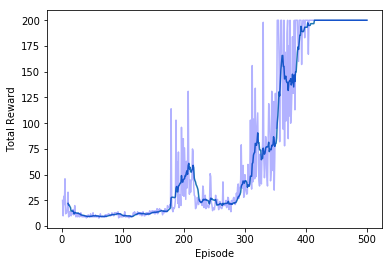

In [240]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

eps, rews = np.array(training_rewards).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='blue', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

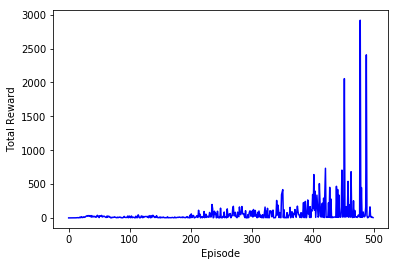

In [241]:
eps, loss = np.array(training_loss).T
plt.plot(loss, color='blue')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()